In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import time

In [3]:
train_df = pd.read_csv('train_small.csv', header=None)
test_df = pd.read_csv('test_small.csv')

In [4]:
idx = features = train_df.columns.values[2:202]
train_df['sum'] = train_df[idx].sum(axis=1)  
train_df['min'] = train_df[idx].min(axis=1)
train_df['max'] = train_df[idx].max(axis=1)
train_df['mean'] = train_df[idx].mean(axis=1)
train_df['std'] = train_df[idx].std(axis=1)
train_df['skew'] = train_df[idx].skew(axis=1)
train_df['kurt'] = train_df[idx].kurtosis(axis=1)
train_df['med'] = train_df[idx].median(axis=1)

In [15]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
2,train_7,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,5.0647,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
3,train_12,8.7671,-4.6154,9.7242,7.4242,9.0254,1.4247,6.2815,12.3143,5.6964,...,0.3782,7.4382,0.0854,1.3444,17.2439,-0.0798,5.7389,8.4897,17.0938,4.6106
4,train_14,13.8080,5.0514,17.2611,8.5120,12.8517,-9.1622,5.7327,21.0517,-4.5117,...,1.0740,8.3220,3.2619,1.6738,17.4797,-0.0257,-3.5323,9.3439,24.4479,-5.1110


In [6]:
train_targets = train_df.iloc[:30000,1]
train_data = train_df.iloc[:30000,2:]
test_targets = train_df.iloc[30000:,1]
test_data = train_df.iloc[30000:,2:]

In [7]:
train_data

,2,3,4,5,6,7,8,9,10,11,...,200,201,sum,min,max,mean,std,skew,kurt,med
0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,18.3560,1.9518,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
1,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,14.7222,0.3965,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
2,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,17.9974,-8.8104,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735
3,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,5.9790,...,12.5809,-4.7602,1272.3216,-44.7257,35.2664,6.361608,9.313012,-0.920439,4.581343,6.23790
4,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,-4.3781,7.9232,...,10.8869,-3.2097,1509.4490,-29.9763,39.9599,7.547245,9.246130,-0.133489,1.816453,7.47605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,14.0635,-1.9707,11.5907,9.1235,9.8390,-10.7132,6.7224,18.9193,5.5894,5.9564,...,18.9036,-7.3718,1333.1630,-20.5967,41.0518,6.665815,9.456337,0.097688,1.148630,6.40610
29996,6.9711,4.4634,10.1643,7.4309,11.3074,0.7672,4.8326,11.3595,1.2632,7.8043,...,10.1544,13.6375,1307.4921,-25.2899,27.8682,6.537460,8.990254,-0.277059,0.751316,6.56235
29997,10.2049,-4.9545,10.8625,7.4219,11.9999,8.7609,5.2583,9.5678,3.5482,8.9106,...,13.8302,-12.9268,1223.4224,-30.6872,41.2369,6.117112,9.136934,-0.019881,2.019095,6.27205
29998,8.5316,-4.5498,9.0770,7.7892,9.4418,6.3046,5.3750,15.5846,4.0439,7.8643,...,16.5477,11.3939,1280.3591,-25.2757,35.8212,6.401795,10.144643,-0.215083,1.069148,6.09795


In [8]:
dtrain = xgb.DMatrix(train_data, label=train_targets)
dtest = xgb.DMatrix(test_data, label=test_targets)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
# specify parameters via map

start = time.time()

param = {'max_depth':1, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 1000
model = xgb.train(param, dtrain, num_round)

end = time.time()
print(end - start)

60.866880893707275


10000 samples took 34.10578370094299 seconds, AUC: 82.2191% 


5000  samples took 13.62356400489807 seconds, AUC: 79.6346% 
    depth 3 : 12 seconds less precise
    depth 1 : 10.697545051574707 s  81.3239% 


30000 samples with depth of 4 took 178.4267921447754 seconds and yielded AUC: 83.2552%

30000 samples with depth of 1 took 60.08928918838501 seconds and yielded AUC: 86.3396% 

In [10]:
# make prediction
preds = model.predict(dtest)

In [11]:

roc = roc_auc_score(test_targets, preds)
print("AUC: %.4f%% " % (roc * 100))

AUC: 86.3396% 


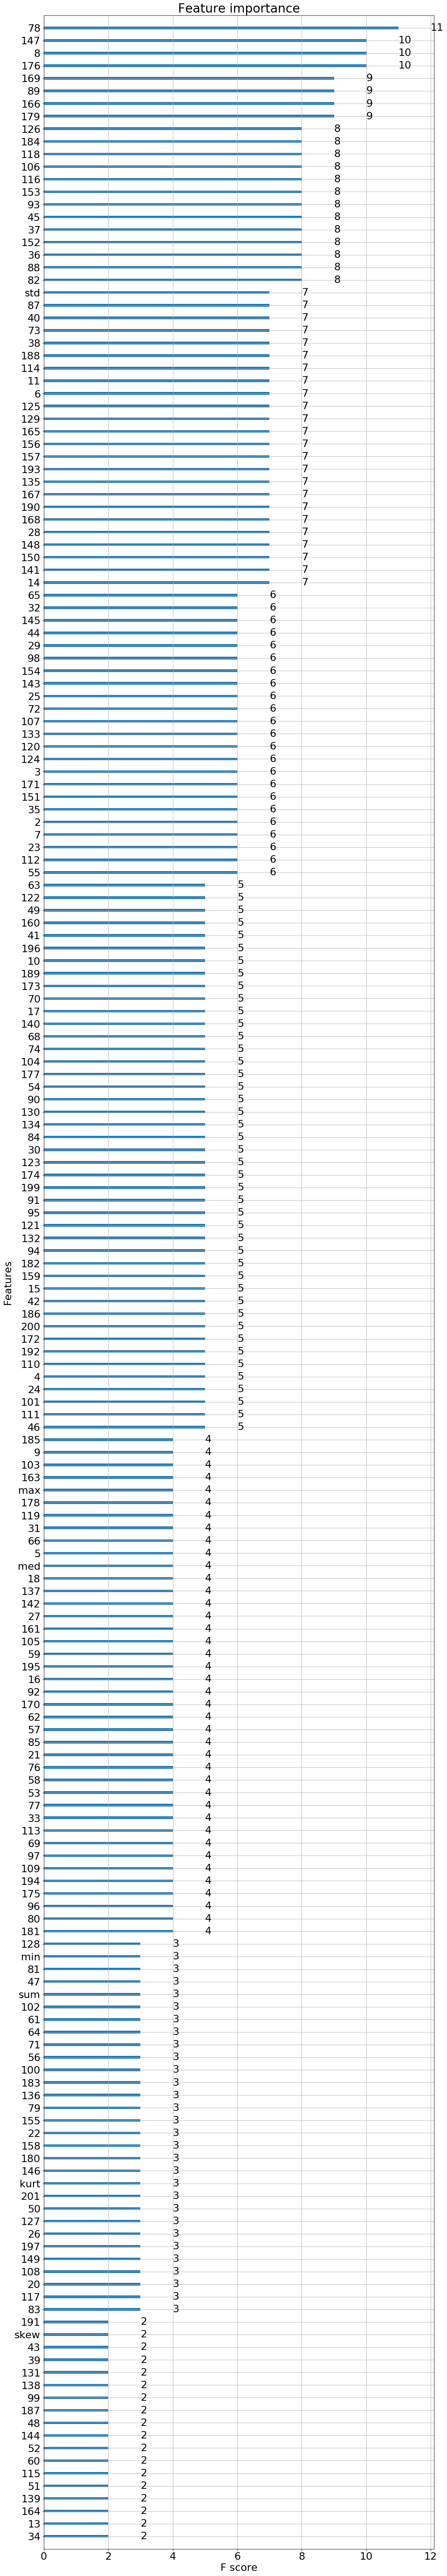

In [12]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 22})
rcParams['figure.figsize'] = 15,100

xgb.plot_importance(model,max_num_features=200)
pyplot.show()

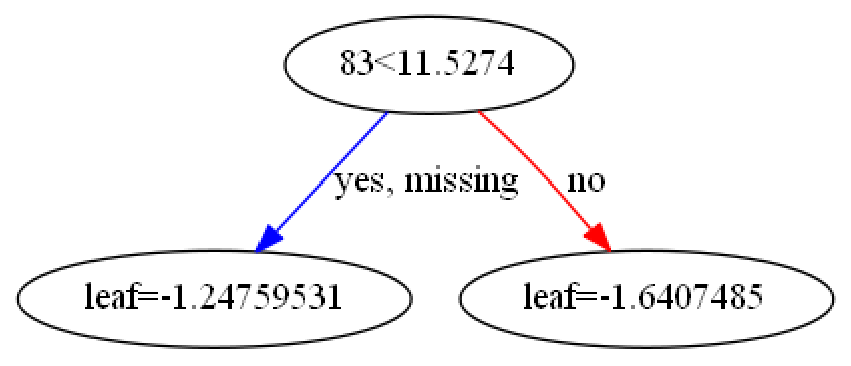

In [13]:
rcParams['figure.figsize'] = 15,15
xgb.plot_tree(model)
pyplot.show()

In [27]:
preds

array([0.02237325, 0.00056479, 0.00016796, ..., 0.0012224 , 0.05021992,
       0.00588612], dtype=float32)

In [34]:
def outputPredictionResultsToCSV(predictions, test_df):
    fileExport = pd.DataFrame(columns=['ID_code', 'target'])
    fileExport['target'] = predictions
    fileExport['ID_code'] = test_df['ID_code']
    fileExport.to_csv('739867+518995-predictions.csv', index_label=False, index=False)
    return fileExport
    
outputPredictionResultsToCSV(preds, test_df)

,ID_code,target
0,train_0,0.022373
1,train_3,0.000565
2,train_7,0.000168
3,train_12,0.010212
4,train_14,0.001561
...,...,...
40052,train_114490,0.002759
40053,train_114491,0.005386
40054,train_114493,0.001222
40055,train_114496,0.050220
